In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from bokeh.io import output_notebook, show, curdoc
from bokeh.layouts import column, row
from bokeh.plotting import figure, curdoc
from bokeh.models import Slider, ColumnDataSource, Div


In [ ]:
# Parameters for the system
alpha = 10       # Maximum production rate
n = 2            # Hill coefficient
gamma = 1        # Degradation rate
Kd = 1           # Dissociation constant
beta = 5         # Memory amplification factor
delta = 0.5      # Memory decay rate
L_max = 10       # Maximum light intensity
light_period = 20 # Time between light bursts
light_duration = 5 # Duration of light bursts

# Light stimulus function (square wave)
def light_stimulus(t):
    if (t % light_period) < light_duration:
        return L_max
    else:
        return 0

# Shape-memory repressilator ODEs
def repressilator_with_memory(t, y):
    A, B, C, M = y  # A, B, C are protein concentrations, M is the memory term
    
    # Light stimulus
    L = light_stimulus(t)
    
    # Memory decay
    dM_dt = beta * L - delta * M
    
    # Repressilator equations with light and memory
    dA_dt = alpha / (1 + (C / Kd)**n) + M - gamma * A
    dB_dt = alpha / (1 + (A / Kd)**n) - gamma * B
    dC_dt = alpha / (1 + (B / Kd)**n) - gamma * C
    
    return [dA_dt, dB_dt, dC_dt, dM_dt]



In [16]:
t_span = (0, 100)
t_eval = np.linspace(*t_span, 1000)


# Initial conditions for multiple trajectories
initial_conditions = [
    [1, 0, 0, 0],   # Default
    [5, 5, 5, 0],   # Mid-range
    [10, 1, 1, 0],  # Higher A
    [1, 10, 10, 0], # Higher B
    [7, 3, 1, 0]    # Mixed
]

In [17]:
# Solve ODEs for each initial condition
solutions = [solve_ivp(repressilator_with_memory, t_span, y0, t_eval=t_eval, method='RK45') for y0 in initial_conditions]

# Define nullclines
B_nullcline = np.linspace(0, 20, 500)  # Expanded range
A_nullcline = alpha / (1 + (B_nullcline / Kd)**n) / gamma  # dB/dt = 0
A_range = np.linspace(0, 20, 500)  # Expanded range
B_nullcline2 = alpha / (1 + (A_range / Kd)**n) / gamma  # dA/dt = 0

# Define a grid for the vector field in A-B phase space
A_vec = np.linspace(0, 20, 50)  # Expanded range for better coverage
B_vec = np.linspace(0, 20, 50)
A_grid, B_grid = np.meshgrid(A_vec, B_vec)

# Memory term (constant for simplicity, adjust as needed for time-dependence)
M_value = 0

# Compute dA/dt and dB/dt for the vector field
C_fixed = 5  # Fix C to a constant value for 2D representation
dA_dt = alpha / (1 + (C_fixed / Kd)**n) + M_value - gamma * A_grid
dB_dt = alpha / (1 + (A_grid / Kd)**n) - gamma * B_grid

plt.figure(figsize=(10, 6))

# Enable non-blocking mode
plt.ion()


<Figure size 1000x600 with 0 Axes>

TypeError: 'int' object is not subscriptable

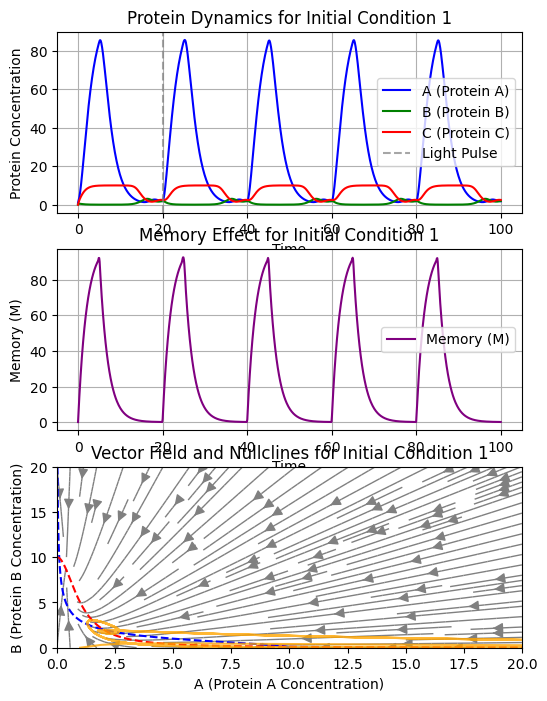

In [28]:
# Plot each trajectory as a separate figure
for idx, (sol, init_cond) in enumerate(zip(solutions, initial_conditions)):
    fig, ax = plt.subplots(3, 1, figsize=(6, 8))

    # Plot protein concentrations
    ax[0].plot(sol.t, sol.y[0], label=f'A (Protein A)', color='blue')
    ax[0].plot(sol.t, sol.y[1], label=f'B (Protein B)', color='green')
    ax[0].plot(sol.t, sol.y[2], label=f'C (Protein C)', color='red')
    ax[0].axvline(x=light_period, color='gray', linestyle='--', alpha=0.7, label='Light Pulse')
    ax[0].set_title(f"Protein Dynamics for Initial Condition {idx+1}")
    ax[0].set_xlabel("Time")
    ax[0].set_ylabel("Protein Concentration")
    ax[0].legend()
    ax[0].grid()

    # Plot memory term
    ax[1].plot(sol.t, sol.y[3], label=f'Memory (M)', color='purple')
    ax[1].set_title(f"Memory Effect for Initial Condition {idx+1}")
    ax[1].set_xlabel("Time")
    ax[1].set_ylabel("Memory (M)")
    ax[1].legend()
    ax[1].grid()

    # Streamline vector field with nullclines
    ax[2].streamplot(A_grid, B_grid, dA_dt, dB_dt, color="gray", linewidth=1, density=1.2, arrowsize=1.5)
    ax[2].plot(A_nullcline, B_nullcline, label=r"$dB/dt = 0$ Nullcline", color='blue', linestyle='--')
    ax[2].plot(A_range, B_nullcline2, label=r"$dA/dt = 0$ Nullcline", color='red', linestyle='--')
    ax[2].plot(sol.y[0], sol.y[1], label="Trajectory", alpha=0.8, color='orange')
    ax[2].set_title(f"Vector Field and Nullclines for Initial Condition {idx+1}")
    ax[2].set_xlabel("A (Protein A Concentration)")
    ax[2].set_ylabel("B (Protein B Concentration)")
    ax[2].set_xlim(0, 20)  # Adjusted x-axis range
    ax[2].set_ylim(0, 20)  # Adjusted y-axis range
    ax[2].legend(fontsize=12, title=f"Initial Condition: A={init_cond[0]}, B={init_cond[1]}, C={init_cond[2]}, M={init_cond[3]}")
    ax[2].grid()

    # Adjust layout
    plt.tight_layout()

# Show all figures at once
plt.show(block=True)


# Gillespie Sims

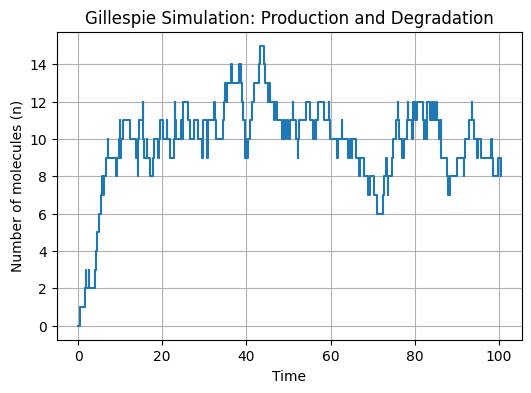

In [31]:


# Parameters
k = 1.0  # Production rate
q = 0.1  # Degradation rate
n0 = 0   # Initial number of molecules
t_max = 100  # Maximum simulation time

# Gillespie simulation
np.random.seed(42)
time = [0]
n_values = [n0]

n = n0
t = 0

while t < t_max:
    # Calculate propensities
    a_production = k
    a_degradation = q * n
    a_total = a_production + a_degradation

    # Break if no reactions can occur
    if a_total == 0:
        break

    # Time to next reaction
    tau = np.random.exponential(1 / a_total)

    # Determine which reaction occurs
    r = np.random.uniform(0, a_total)
    if r < a_production:
        # Production reaction
        n += 1
    else:
        # Degradation reaction
        n -= 1 if n > 0 else 0

    # Update time and record values
    t += tau
    time.append(t)
    n_values.append(n)

# Plot the results
plt.figure(figsize=(6, 4))
plt.step(time, n_values, where="post")
plt.xlabel("Time")
plt.ylabel("Number of molecules (n)")
plt.title("Gillespie Simulation: Production and Degradation")
plt.grid(True)
plt.show()

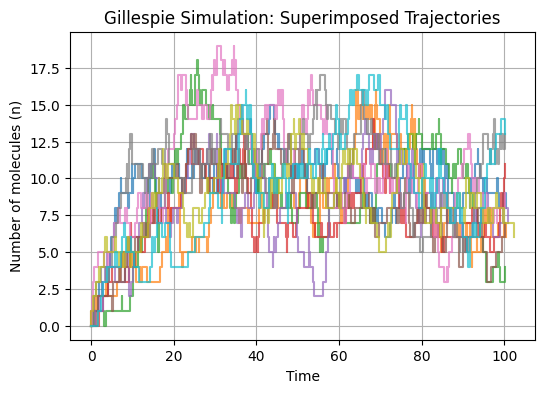

In [32]:
# Parameters
k = 1.0  # Production rate
q = 0.1  # Degradation rate
n0 = 0   # Initial number of molecules
t_max = 100  # Maximum simulation time
num_simulations = 10  # Number of Gillespie trajectories

# Gillespie function
def gillespie_simulation(k, q, n0, t_max):
    time = [0]
    n_values = [n0]

    n = n0
    t = 0

    while t < t_max:
        # Calculate propensities
        a_production = k
        a_degradation = q * n
        a_total = a_production + a_degradation

        # Break if no reactions can occur
        if a_total == 0:
            break

        # Time to next reaction
        tau = np.random.exponential(1 / a_total)

        # Determine which reaction occurs
        r = np.random.uniform(0, a_total)
        if r < a_production:
            # Production reaction
            n += 1
        else:
            # Degradation reaction
            n -= 1 if n > 0 else 0

        # Update time and record values
        t += tau
        time.append(t)
        n_values.append(n)

    return time, n_values

# Run multiple simulations
np.random.seed(42)
all_trajectories = [gillespie_simulation(k, q, n0, t_max) for _ in range(num_simulations)]

# Plot the results
plt.figure(figsize=(6,4))

for time, n_values in all_trajectories:
    plt.step(time, n_values, where="post", alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Number of molecules (n)")
plt.title("Gillespie Simulation: Superimposed Trajectories")
plt.grid(True)
plt.show()

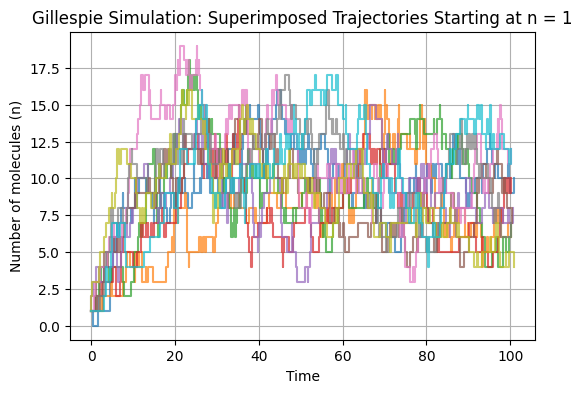

In [33]:
# Parameters
k = 1.0  # Production rate
q = 0.1  # Degradation rate
n0 = 1   # Start all simulations with n = 1
t_max = 100  # Maximum simulation time
num_simulations = 10  # Number of Gillespie trajectories

# Gillespie function
def gillespie_simulation(k, q, n0, t_max):
    time = [0]
    n_values = [n0]

    n = n0
    t = 0

    while t < t_max:
        # Calculate propensities
        a_production = k
        a_degradation = q * n
        a_total = a_production + a_degradation

        # Break if no reactions can occur
        if a_total == 0:
            break

        # Time to next reaction
        tau = np.random.exponential(1 / a_total)

        # Determine which reaction occurs
        r = np.random.uniform(0, a_total)
        if r < a_production:
            # Production reaction
            n += 1
        else:
            # Degradation reaction
            n -= 1 if n > 0 else 0

        # Update time and record values
        t += tau
        time.append(t)
        n_values.append(n)

    return time, n_values

# Run multiple simulations
np.random.seed(42)
all_trajectories = [gillespie_simulation(k, q, n0, t_max) for _ in range(num_simulations)]

# Plot the results
plt.figure(figsize=(6,4))

for time, n_values in all_trajectories:
    plt.step(time, n_values, where="post", alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Number of molecules (n)")
plt.title("Gillespie Simulation: Superimposed Trajectories Starting at n = 1")
plt.grid(True)
plt.show()

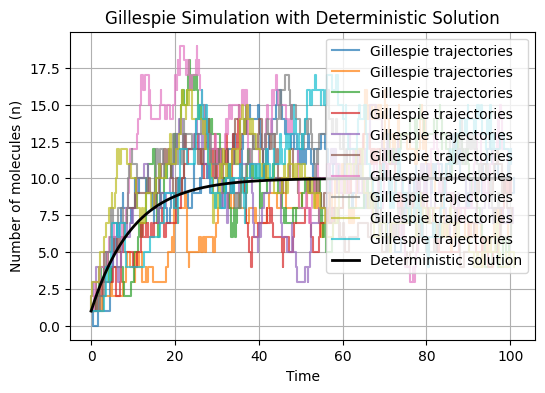

In [34]:
# Parameters
k = 1.0  # Production rate
q = 0.1  # Degradation rate
n0 = 1   # Start all simulations with n = 1
t_max = 100  # Maximum simulation time
num_simulations = 10  # Number of Gillespie trajectories

# Gillespie function
def gillespie_simulation(k, q, n0, t_max):
    time = [0]
    n_values = [n0]

    n = n0
    t = 0

    while t < t_max:
        # Calculate propensities
        a_production = k
        a_degradation = q * n
        a_total = a_production + a_degradation

        # Break if no reactions can occur
        if a_total == 0:
            break

        # Time to next reaction
        tau = np.random.exponential(1 / a_total)

        # Determine which reaction occurs
        r = np.random.uniform(0, a_total)
        if r < a_production:
            # Production reaction
            n += 1
        else:
            # Degradation reaction
            n -= 1 if n > 0 else 0

        # Update time and record values
        t += tau
        time.append(t)
        n_values.append(n)

    return time, n_values

# Deterministic solution
def deterministic_solution(k, q, n0, t):
    return (k / q) * (1 - np.exp(-q * t)) + n0 * np.exp(-q * t)

# Run Gillespie simulations
np.random.seed(42)
all_trajectories = [gillespie_simulation(k, q, n0, t_max) for _ in range(num_simulations)]

# Generate time points for deterministic simulation
t_deterministic = np.linspace(0, t_max, 1000)
n_deterministic = deterministic_solution(k, q, n0, t_deterministic)

# Plot the results
plt.figure(figsize=(6,4))

# Plot Gillespie trajectories
for time, n_values in all_trajectories:
    plt.step(time, n_values, where="post", alpha=0.7, label="Gillespie trajectories")

# Plot deterministic solution
plt.plot(t_deterministic, n_deterministic, color="black", lw=2, label="Deterministic solution")

# Add labels, legend, and grid
plt.xlabel("Time")
plt.ylabel("Number of molecules (n)")
plt.title("Gillespie Simulation with Deterministic Solution")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

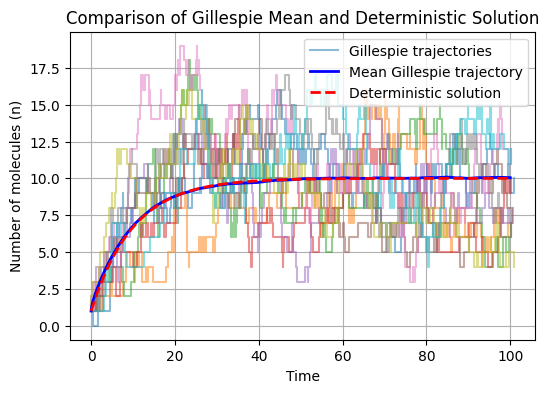

In [35]:
# Parameters
k = 1.0  # Production rate
q = 0.1  # Degradation rate
n0 = 1   # Start all simulations with n = 1
t_max = 100  # Maximum simulation time
num_simulations = 10000  # Number of Gillespie trajectories

# Gillespie function
def gillespie_simulation(k, q, n0, t_max):
    time = [0]
    n_values = [n0]

    n = n0
    t = 0

    while t < t_max:
        # Calculate propensities
        a_production = k
        a_degradation = q * n
        a_total = a_production + a_degradation

        # Break if no reactions can occur
        if a_total == 0:
            break

        # Time to next reaction
        tau = np.random.exponential(1 / a_total)

        # Determine which reaction occurs
        r = np.random.uniform(0, a_total)
        if r < a_production:
            # Production reaction
            n += 1
        else:
            # Degradation reaction
            n -= 1 if n > 0 else 0

        # Update time and record values
        t += tau
        time.append(t)
        n_values.append(n)

    return time, n_values

# Deterministic solution
def deterministic_solution(k, q, n0, t):
    return (k / q) * (1 - np.exp(-q * t)) + n0 * np.exp(-q * t)

# Run Gillespie simulations
np.random.seed(42)
all_trajectories = [gillespie_simulation(k, q, n0, t_max) for _ in range(num_simulations)]

# Time grid for averaging
t_grid = np.linspace(0, t_max, 1000)
mean_values = np.zeros_like(t_grid)

# Interpolate and average Gillespie results
for time, n_values in all_trajectories:
    interpolated = np.interp(t_grid, time, n_values)
    mean_values += interpolated / num_simulations

# Deterministic solution
n_deterministic = deterministic_solution(k, q, n0, t_grid)

# Plot the results
plt.figure(figsize=(6,4))

# Plot Gillespie trajectories (optional: for visualization, plot a subset)
for time, n_values in all_trajectories[:10]:  # Show only 10 trajectories for clarity
    plt.step(time, n_values, where="post", alpha=0.5, label="Gillespie trajectories" if time is all_trajectories[0][0] else "")

# Plot mean trajectory
plt.plot(t_grid, mean_values, color="blue", lw=2, label="Mean Gillespie trajectory")

# Plot deterministic solution
plt.plot(t_grid, n_deterministic, color="red", lw=2, linestyle="--", label="Deterministic solution")

# Add labels, legend, and grid
plt.xlabel("Time")
plt.ylabel("Number of molecules (n)")
plt.title("Comparison of Gillespie Mean and Deterministic Solution")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# Interactive Plotting